### Pre Processing

In [49]:
import os
os.getcwd()

'C:\\CSC_669'

In [48]:
os.chdir('../../CSC_669')
os.listdir()

['checkpoints',
 'test_data_v2.zip',
 'train.csv',
 'train_data',
 'train_data.zip']

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [30]:
# print(len(os.listdir(os.getcwd())

79950


In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import timm

In [51]:
# Load the CSV file
csv_path = './train.csv'
data = pd.read_csv(csv_path)

# Extract image paths and labels
image_paths = data['file_name'].values
labels = data['label'].values

In [77]:
data['label'].value_counts()

label
1    39975
0    39975
Name: count, dtype: int64

In [53]:
import warnings
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            # Attempt to load the image
            image = Image.open(image_path).convert('RGB')
        except FileNotFoundError:
            # Log a warning and return a placeholder (e.g., a blank image)
            warnings.warn(f"Image not found: {image_path}. Skipping this sample.")
            return None, None

        if self.transform:
            image = self.transform(image)

        return image, label

In [54]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to Swin Transformer input size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

In [55]:
# Create dataset
dataset = CustomDataset(image_paths, labels, transform=transform)

# Create dataloader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

### Training

In [56]:
# Load Swin Transformer
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=2)  # Adjust num_classes as needed
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10  
checkpoint_interval = 5 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_images, batch_labels in dataloader:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

    # Save model weights every 5 epochs
    if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), checkpoint_path)
        print(f'Saved model weights to {checkpoint_path}')

Epoch [1/10], Loss: 0.0190
Epoch [2/10], Loss: 0.0077
Epoch [3/10], Loss: 0.0078
Epoch [4/10], Loss: 0.0052
Epoch [5/10], Loss: 0.0059
Saved model weights to checkpoints\model_epoch_5.pth
Epoch [6/10], Loss: 0.0046
Epoch [7/10], Loss: 0.0051
Epoch [8/10], Loss: 0.0034
Epoch [9/10], Loss: 0.0033
Epoch [10/10], Loss: 0.0031
Saved model weights to checkpoints\model_epoch_10.pth


In [81]:
#Resume Training

checkpoint_path = 'checkpoints/model_epoch_10.pth'  # Example path
model.load_state_dict(torch.load(checkpoint_path))
model.to(device)
print(f'Loaded model weights from {checkpoint_path}')

num_epochs = 20  
checkpoint_interval = 5 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_images, batch_labels in dataloader:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

    # Save model weights every 5 epochs
    if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), checkpoint_path)
        print(f'Saved model weights to {checkpoint_path}')

Loaded model weights from checkpoints/model_epoch_10.pth
Epoch [1/20], Loss: 0.0002
Epoch [2/20], Loss: 0.0002
Epoch [3/20], Loss: 0.0003
Epoch [4/20], Loss: 0.0001
Epoch [5/20], Loss: 0.0002
Saved model weights to checkpoints\model_epoch_5.pth
Epoch [6/20], Loss: 0.0002
Epoch [7/20], Loss: 0.0003
Epoch [8/20], Loss: 0.0002
Epoch [9/20], Loss: 0.0002
Epoch [10/20], Loss: 0.0002
Saved model weights to checkpoints\model_epoch_10.pth
Epoch [11/20], Loss: 0.0003
Epoch [12/20], Loss: 0.0002
Epoch [13/20], Loss: 0.0002
Epoch [14/20], Loss: 0.0002
Epoch [15/20], Loss: 0.0002
Saved model weights to checkpoints\model_epoch_15.pth
Epoch [16/20], Loss: 0.0003
Epoch [17/20], Loss: 0.0002
Epoch [18/20], Loss: 0.0002
Epoch [19/20], Loss: 0.0002
Epoch [20/20], Loss: 0.0003
Saved model weights to checkpoints\model_epoch_20.pth


### Testing

In [82]:
import pandas as pd

test_csv_path = './test.csv'
test_data = pd.read_csv(test_csv_path)

# Extract image paths
test_image_paths = test_data['id'].values  # Assuming the column is named 'image_path'

In [83]:
from torch.utils.data import Dataset
from PIL import Image
import warnings

class TestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert('RGB')
        except FileNotFoundError:
            warnings.warn(f"Image not found: {image_path}. Skipping this sample.")
            return None, image_path  # Return the path for debugging

        if self.transform:
            image = self.transform(image)

        return image, image_path

In [84]:
from torchvision import transforms

# Define transformations (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create test dataset
test_dataset = TestDataset(test_image_paths, transform=transform)

# Create test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [85]:
import timm
import torch

# Load the model architecture
model = timm.create_model('swin_base_patch4_window7_224', pretrained=False, num_classes=2)  # Adjust num_classes as needed
model = model.to(device)

# Load the trained weights
checkpoint_path = './checkpoints/model_epoch_20.pth'  # Replace with your saved weights path
model.load_state_dict(torch.load(checkpoint_path))
model.eval()  # Set the model to evaluation mode

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

In [86]:
predictions = []
image_paths = []

with torch.no_grad():  # Disable gradient computation
    for batch_images, batch_paths in test_dataloader:
        if batch_images is None:  # Skip batches with missing images
            continue

        batch_images = batch_images.to(device)

        # Forward pass
        outputs = model(batch_images)
        _, preds = torch.max(outputs, 1)  # Get predicted class indices

        # Store predictions and image paths
        predictions.extend(preds.cpu().numpy())
        image_paths.extend(batch_paths)

In [87]:
results = pd.DataFrame({
    'image_path': image_paths,
    'prediction': predictions
})

In [88]:
submission_df = pd.DataFrame({
    'image_path': results['image_path'],
    'label': results['prediction']
})

In [89]:
submission_df.to_csv('submission_2.csv', index=False)
print("Submission file saved to 'submission_2.csv'")

Submission file saved to 'submission_2.csv'


### Improving the score

Submission file saved to 'submission.csv'
Sample predictions:
Image: test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg, Predicted: 0
Image: test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg, Predicted: 0
Image: test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg, Predicted: 0
Image: test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg, Predicted: 0
Image: test_data_v2/a16495c578b7494683805484ca27cf9f.jpg, Predicted: 0
Visualizing sample predictions:


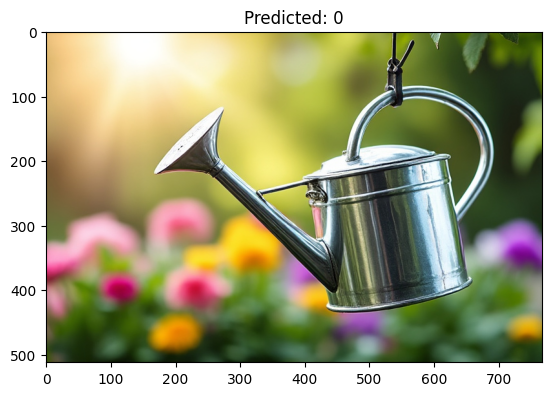

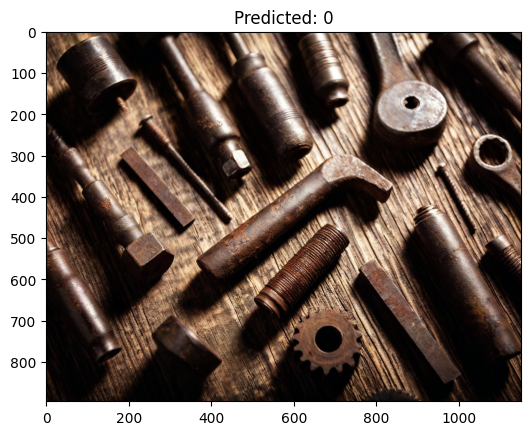

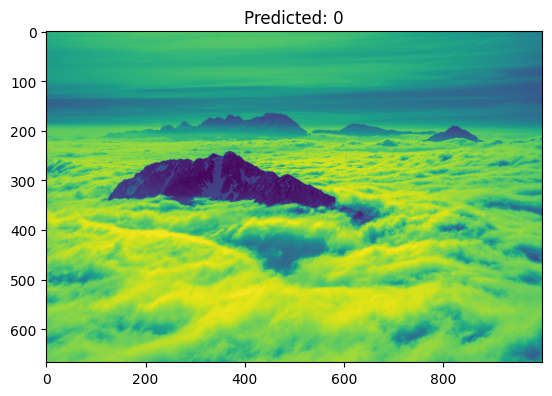

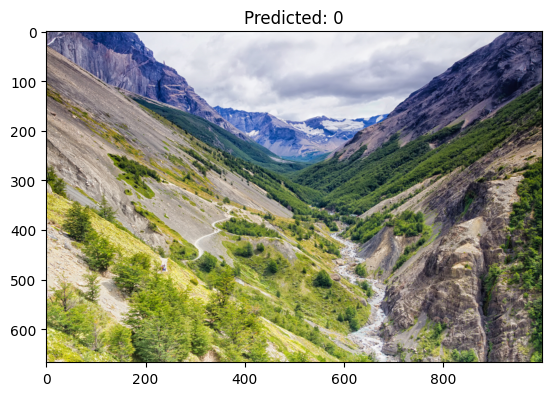

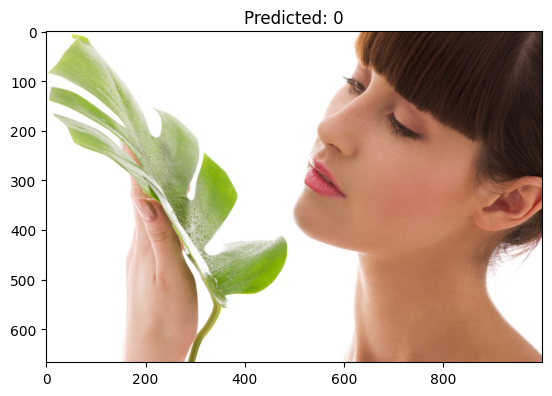

Prediction distribution:
prediction
0    5063
1     477
Name: count, dtype: int64


In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import timm
import warnings
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load test CSV
test_csv_path = './test.csv'
test_data = pd.read_csv(test_csv_path)

# Extract image paths
test_image_paths = test_data['id'].values

# Define transformations (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define test dataset class
class TestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert('RGB')
        except FileNotFoundError:
            warnings.warn(f"Image not found: {image_path}. Skipping this sample.")
            return None, image_path  # Return the path for debugging

        if self.transform:
            image = self.transform(image)

        return image, image_path

# Create test dataset and dataloader
test_dataset = TestDataset(test_image_paths, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the trained model
model = timm.create_model('swin_base_patch4_window7_224', pretrained=False, num_classes=2)  # Adjust num_classes as needed
model = model.to(device)

# Load trained weights
checkpoint_path = './checkpoints/model_epoch_20.pth'  # Replace with your saved weights path
model.load_state_dict(torch.load(checkpoint_path))
model.eval()  # Set model to evaluation mode

# Run inference
predictions = []
image_paths = []

with torch.no_grad():  # Disable gradient computation
    for batch_images, batch_paths in test_dataloader:
        if batch_images is None:  # Skip batches with missing images
            continue

        batch_images = batch_images.to(device)

        # Forward pass
        outputs = model(batch_images)
        _, preds = torch.max(outputs, 1)  # Get predicted class indices

        # Store predictions and image paths
        predictions.extend(preds.cpu().numpy())
        image_paths.extend(batch_paths)

# Create a DataFrame with predictions
results = pd.DataFrame({
    'image_path': image_paths,
    'prediction': predictions
})

# Save predictions to CSV
submission_df = pd.DataFrame({
    'image_path': results['image_path'],
    'label': results['prediction']
})
submission_df.to_csv('submission_2.csv', index=False)
print("Submission file saved to 'submission.csv'")

# Analyze predictions
print("Sample predictions:")
for i in range(5):  # Print first 5 predictions
    print(f"Image: {results['image_path'][i]}, Predicted: {results['prediction'][i]}")

# Visualize predictions
print("Visualizing sample predictions:")
for i in range(5):  # Display first 5 images with predictions
    image_path = results['image_path'][i]
    prediction = results['prediction'][i]

    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"Predicted: {prediction}")
    plt.show()

# Check for class distribution in predictions
print("Prediction distribution:")
print(results['prediction'].value_counts())

In [95]:
test_data = pd.read_csv('./submission_2.csv')
test_label_counts = test_data['label'].value_counts()
print(test_label_counts)

label
0    5063
1     477
Name: count, dtype: int64
